# Detecção de Intrusões em Redes Usando Isolation Forest

## 1. Introdução

A segurança em redes de computadores é essencial para proteger sistemas contra ameaças como DoS, DDoS e varreduras de portas, que podem comprometer a integridade e disponibilidade dos serviços. Técnicas de aprendizado de máquina, como Random Forest, são eficazes na detecção automática de intrusões por meio da análise de padrões em dados de tráfego de rede. Este trabalho aplica o Random Forest para classificar eventos de rede, visando melhorar a identificação rápida e precisa de ataques cibernéticos.    

## 2. Fundamentação Teórica

Neste estudo, será utilizada a técnica de **Isolation Forest**, uma abordagem não supervisionada voltada para a detecção de anomalias. Esse método isola observações atípicas por meio da construção de múltiplas árvores de partição aleatória, identificando instâncias que exigem menos divisões para serem isoladas. O Isolation Forest é reconhecido por sua eficiência em conjuntos de dados tabulares e por sua capacidade de detectar comportamentos anômalos sem a necessidade de rótulos previamente definidos.

## 3. Metodologia

O dataset escolhido foi retirado da plataforma Kaggle:  
> [Network Intrusion Detection Dataset](https://www.kaggle.com/datasets/sampadab17/network-intrusion-detection)

O conjunto contém registros de tráfego de rede rotulados como normal ou pertencentes a diferentes tipos de ataques.

As etapas metodológicas incluem:

- Carregamento e visualização dos dados
- Limpeza e pré-processamento
- Treinamento do modelo
- Avaliação usando métricas padrão
    

# Pré-Processamento

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [3]:

# 4.2 Carregamento do dataset
df = pd.read_csv("Train_data.csv")

# Visualização inicial
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [4]:
print(df.columns)

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class'],
      dtype='object')


In [5]:
# Colunas categóricas nominais
colunas_categoricas = ['protocol_type', 'flag', 'service']

# Dicionário para armazenar os encoders caso precise inverter depois
encoders = {}

for coluna in colunas_categoricas:
    le = LabelEncoder()
    df[coluna] = le.fit_transform(df[coluna])
    encoders[coluna] = le  # Guarda o encoder para possível inversão futura

# # Prints para análise (comente/descomente conforme desejar)
#print(df[colunas_categoricas].head())
# print(df['protocol_type'].unique())
# print(df['flag'].unique())
# print(df['service'].unique())

# Contar valores únicos por coluna
# print(df.nunique().sort_values())

# Verificar colunas com valores nulos
# print(df.isnull().sum())

# Verifica se cada valor é string (ou seja, não numérico)
nao_numericos_por_coluna = df.map(lambda x: isinstance(x, str)).sum()

# Mostrar as colunas que têm algum valor não numérico
#print(nao_numericos_por_coluna[nao_numericos_por_coluna > 0])

# Renomeando para Label para evitar confusão
df.rename(columns={'class': 'Label'}, inplace=True)

# Codificar a coluna alvo
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

    

In [6]:
# Separar atributos e rótulo
X = df.drop('Label', axis=1)
y = df['Label']

# Dividir em treino e teste (random_state para reprodutibilidade)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# # Prints para conferir tamanho dos conjuntos
# print(f'Treino: {X_train.shape}, Teste: {X_test.shape}')

# Treinamento do Modelo

In [7]:
# 4.4 Treinamento do modelo
model = IsolationForest(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Previsão
y_pred = model.predict(X_test)

# Avaliação do Modelo

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# O IsolationForest retorna 1 (normal) e -1 (anomalia)
# Se no dataset '1' for ataque, vamos inverter:
y_pred_adjusted = [1 if p == -1 else 0 for p in y_pred]

print("Matriz de confusão:")
print(confusion_matrix(y_test, y_pred_adjusted))

print("\nAcurácia:")
print(accuracy_score(y_test, y_pred_adjusted))

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_adjusted, zero_division=0))



Matriz de confusão:
[[3057  466]
 [3783  252]]

Acurácia:
0.4378142365705213

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.45      0.87      0.59      3523
           1       0.35      0.06      0.11      4035

    accuracy                           0.44      7558
   macro avg       0.40      0.47      0.35      7558
weighted avg       0.40      0.44      0.33      7558



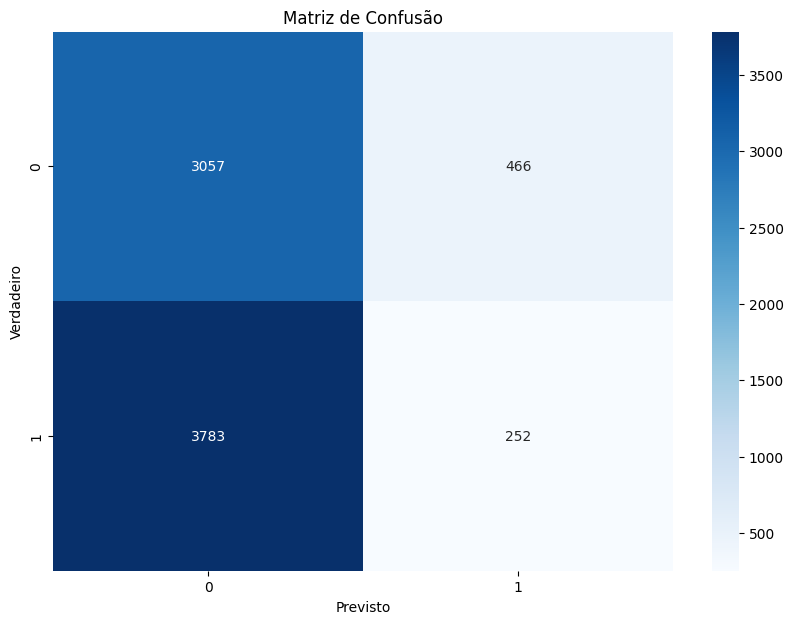

In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão")
plt.show()



ROC AUC (Quão bem o modelo separa classes normais de Anômalas): 0.2579


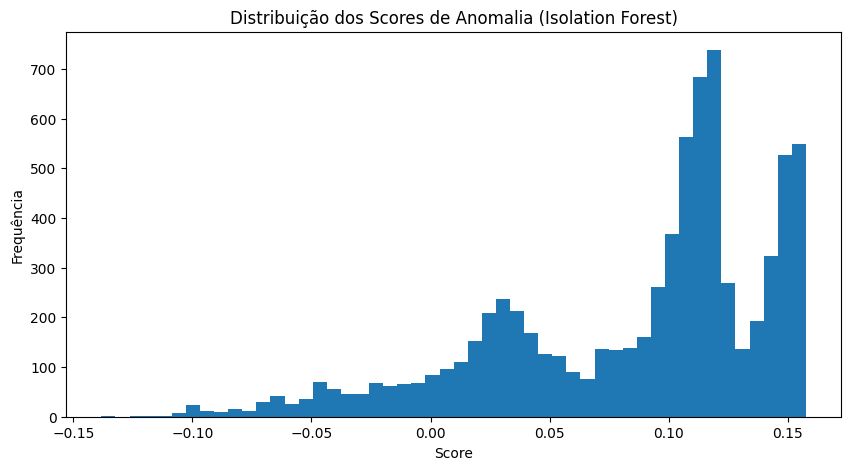

descrição: Quanto menor o score, mais chance de ser anômalo


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, -model.decision_function(X_test))
print(f"ROC AUC (Quão bem o modelo separa classes normais de Anômalas): {roc_auc:.4f}")

anomaly_scores = model.decision_function(X_test)

plt.figure(figsize=(10,5))
plt.hist(anomaly_scores, bins=50)
plt.title("Distribuição dos Scores de Anomalia (Isolation Forest)")
plt.xlabel("Score")
plt.ylabel("Frequência")
plt.show()
print("descrição: Quanto menor o score, mais chance de ser anômalo")

Valores únicos em 'Predito': [ 1 -1]

=Top 10 features sem normalização:
src_bytes             27904.329441
duration               3298.978549
dst_bytes               558.076392
dst_host_srv_count       66.967255
dst_host_count           29.731160
count                    17.720951
service                   7.055054
srv_count                 5.167447
num_root                  3.269811
flag                      3.260664
Name: Diff, dtype: float64


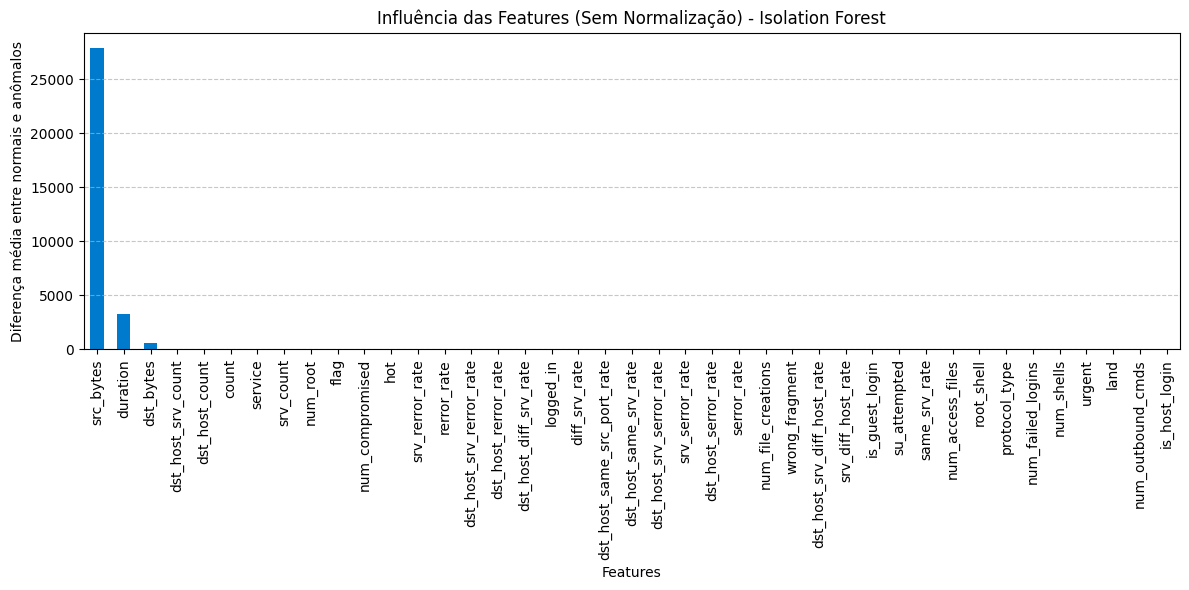


Top 10 features com normalização:
dst_host_diff_srv_rate         1.944739
srv_rerror_rate                1.762331
rerror_rate                    1.754694
dst_host_srv_rerror_rate       1.716580
dst_host_rerror_rate           1.625377
diff_srv_rate                  1.312305
flag                           1.219442
duration                       1.076530
dst_host_same_src_port_rate    0.691263
dst_host_srv_count             0.606747
Name: Diff, dtype: float64


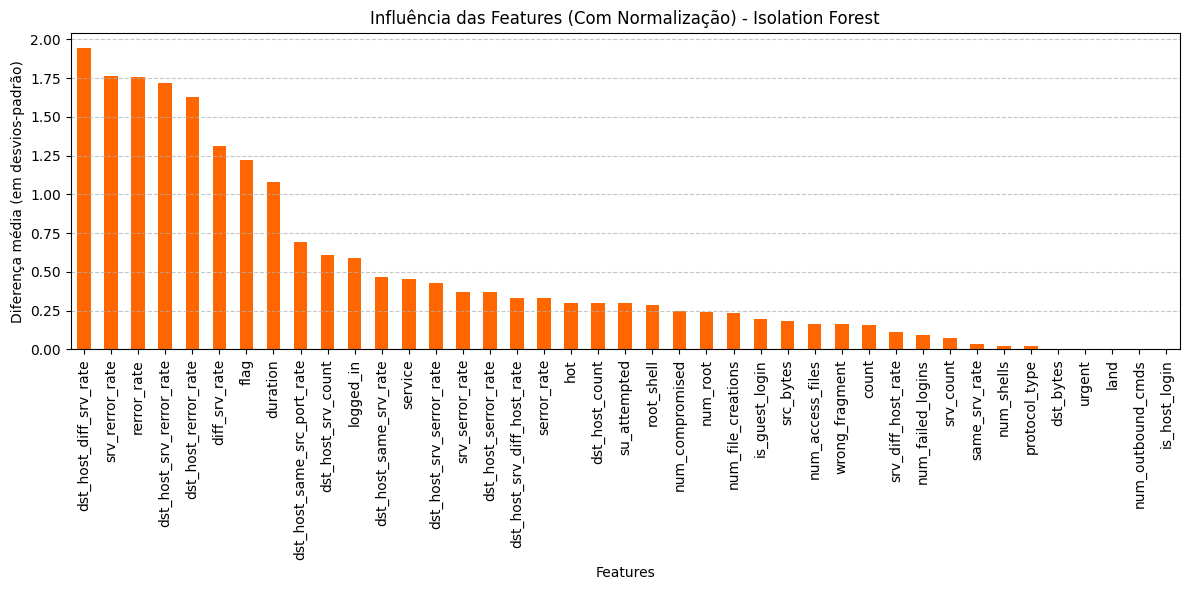

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Cria dataframe base para analise
df_result_raw = X_test.copy()
df_result_raw["Predito"] = y_pred  # 0 = normal, 1 = anomalia

print("Valores únicos em 'Predito':", df_result_raw["Predito"].unique())

if len(df_result_raw["Predito"].unique()) < 2:
    print("⚠️ Aviso: o modelo detectou apenas uma classe (tudo normal ou tudo anômalo).")
else:
    # Sem Normalização de dados
    feature_diff_raw = df_result_raw.groupby("Predito").mean().T
    labels = list(df_result_raw["Predito"].unique())
    feature_diff_raw["Diff"] = abs(feature_diff_raw[labels[0]] - feature_diff_raw[labels[1]])
    feature_diff_raw = feature_diff_raw["Diff"].sort_values(ascending=False)

    print("\n=Top 10 features sem normalização:")
    print(feature_diff_raw.head(10))

    plt.figure(figsize=(12,6))
    feature_diff_raw.plot(kind='bar', color="#007ACC")
    plt.title("Influência das Features (Sem Normalização) - Isolation Forest")
    plt.xlabel("Features")
    plt.ylabel("Diferença média entre normais e anômalos")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Com Normalização de dados
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)
    df_result_scaled = X_scaled.copy()
    df_result_scaled["Predito"] = y_pred

    feature_diff_scaled = df_result_scaled.groupby("Predito").mean().T
    feature_diff_scaled["Diff"] = abs(feature_diff_scaled[labels[0]] - feature_diff_scaled[labels[1]])
    feature_diff_scaled = feature_diff_scaled["Diff"].sort_values(ascending=False)

    print("\nTop 10 features com normalização:")
    print(feature_diff_scaled.head(10))

    plt.figure(figsize=(12,6))
    feature_diff_scaled.plot(kind='bar', color="#FF6600")
    plt.title("Influência das Features (Com Normalização) - Isolation Forest")
    plt.xlabel("Features")
    plt.ylabel("Diferença média (em desvios-padrão)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


### Observação:
- O primeiro gráfico mostra as diferenças absolutas nas unidades originais das features.
- O segundo gráfico mostra as diferenças relativas (dados padronizados).
- Normalizamos no Isolation Forest para que todas as features tenham igual influência na detecção de anomalias, evitando que a escala de uma variável distorça o isolamento.
- A normalização evita que atributos com escala grande (ex.: bytes, tempo) dominem o resultado.
- Assim, o segundo gráfico costuma refletir melhor as features mais relevantes para a detecção de anomalias.